Testing how using different priors on the slope parameters changes posteriors

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import corner
import emcee

Define model function

In [2]:
def model(m, c, x):
    return m * x + c

Prior

In [4]:
def jake_lnprior(pars):
    alpha, beta, sigma = pars
    if sigma < 0:
        return -np.inf
    else:
        return -1.5 * np.log(1 + beta ** 2) - np.log(sigma)

Log prob

In [6]:
def jake_lnprob(pars, x, y, yerr):
    return jake_lnprior(pars) + lnlike(pars, x, y, yerr)

Likelihood

In [33]:
#def lnlike(pars, x, y, yerr):
#    m, c, s = pars
#    invsig2 = 1./(yerr**2 + np.exp(2*s))
#    model_y = model(m, c, x)
#    return -.5*np.sum((y-model_y)**2*invsig2 - np.log(invsig2))

def lnlike(theta, x, y, yerr):
    m, c, s = theta
    invsig2 = 1./(yerr**2 + s**2)
    return -.5*np.sum((y-model(m, c, x))**2*invsig2 - np.log(invsig2))
    #return -0.5 * np.sum(np.log(2 * np.pi * sigma ** 2) + (y - y_model) ** 2 / sigma ** 2)

Plot the data

params =  -0.525509606298 2.88909102256


/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


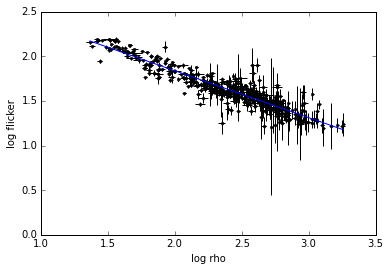

In [8]:
# load data
f, ferr, r, rerr = np.genfromtxt("../data/flickers.dat").T

# fit a line
AT = np.vstack((r, np.ones_like(r)))
ATA = np.dot(AT, AT.T)
m, c = np.linalg.solve(ATA, np.dot(AT, f))
print("params = ", m, c)

# plot data with best fit line
xs = np.linspace(min(r), max(r), 100)
ys = m * xs + c
plt.errorbar(r, f, xerr=rerr, yerr=ferr, fmt="k.", capsize=0)
plt.plot(xs, ys)
plt.ylabel("log flicker")
plt.xlabel("log rho")

Run emcee

In [21]:
pars_init = [m, c, np.log(3)]
print(lnlike(pars_init, r, f, ferr)) # check the lhf works
print(jake_lnprob(pars_init, r, f, ferr)) # check the lhf works
print(jake_lnprior(pars_init)) # check the lhf works

-482.639922813
-486.086529232
-3.44660641822


In [34]:
ndim, nwalkers = 3, 24
pos = [pars_init + 1e-4 * np.random.randn(ndim) for i in range(nwalkers)]  # initialisation
sampler = emcee.EnsembleSampler(nwalkers, ndim, jake_lnprob, args=(r, f, ferr))
sampler.run_mcmc(pos, 10000)  # run MCMC
samples = sampler.chain[:, 1000:, :].reshape((-1, ndim))  # cut off burn in and flatten chains
m2, c2, ln_sig2 = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [16, 50, 84], axis=0)))
print(m2)
print(c2)
print(ln_sig2)

(-0.52549821149473053, 0.0092743522485583263, 0.0091487330796569122)
(2.8917496265483518, 0.021200870986355369, 0.021341513865689166)
(0.065833111867525079, 0.0029595075902019014, 0.0028027612406090335)


/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


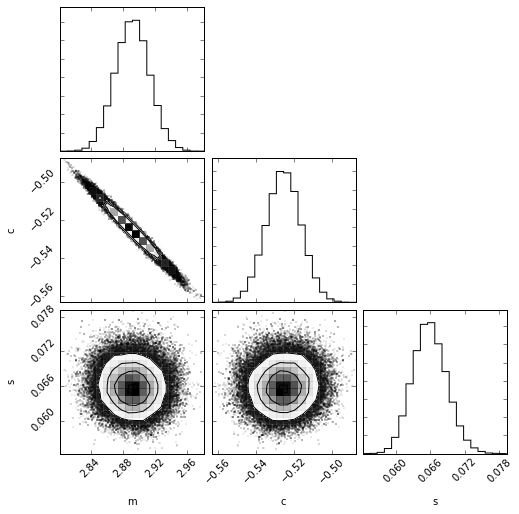

In [30]:
fig = corner.corner(samples, labels=["m", "c", "s"])